# Text Classification

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display_png
from gensim.models import word2vec, KeyedVectors
from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, Dropout, Flatten, GlobalAveragePooling1D,Conv1D
from keras.utils import to_categorical, plot_model, pad_sequences
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
!gdown 1hi4wVX7EXyNNLU0V-DRD6h2b4YwsLnM5

Downloading...
From: https://drive.google.com/uc?id=1hi4wVX7EXyNNLU0V-DRD6h2b4YwsLnM5
To: /content/wongnai-data.zip
100% 15.1M/15.1M [00:00<00:00, 50.9MB/s]


In [3]:
!unzip wongnai-data.zip

Archive:  wongnai-data.zip
  inflating: wongnai-dev.csv         
  inflating: wongnai-test.csv        
  inflating: wongnai-train.csv       


In [4]:
#load data
train = pd.read_csv('wongnai-train.csv', encoding='utf-8')
dev = pd.read_csv('wongnai-dev.csv', encoding='utf-8')
test = pd.read_csv('wongnai-test.csv', encoding='utf-8')

# show data
train

,star,tokenized
0,5,มา|ตามคำแนะนำ|จาก|เพจ| |kin| |dee| |by| |praew...
1,5,บรรยากาศ|ร้าน|น่า|นั่ง|สไตล์|ญี่ปุ่น| |อาหาร|อ...
2,5,หน้า|ร้าน|เล็ก|ๆ| |แต่|เข้าไป|มี|พื้นที่|พอสมค...
3,4,It|'|s| |really| |good| |that| |After| |You| |...
4,3,มา|ทาน|ร้าน|นี้|ตั้งแต่|ร้าน|ยัง|ไม่|มี|ห้อง|แ...
...,...,...
23995,3,สาขา|ฟิวเจอร์|รังสิต| |วันอาทิตย์|คน|เยอะ|มาก|...
23996,4,ติ๋ม|ซำ|หลากหลาย|หน้า| |ชิ้น|ค่อนข้าง|เล็ก| |ร...
23997,5,ขับ|มา|ระหว่างทาง|จาก|ระยอง|จะ|ไป|จังหวัด|จันท...
23998,4,ร้าน|นี้|ตั้งอยู่|ริมถนน|พระราม| |3| |จะ|อยู่...


In [5]:
# Add a new column called "length" to the train and dev DataFrames, which contains the number of tokens in each review.
train['length'] = train['tokenized'].apply(lambda x: x.count('|'))
dev['length'] = dev['tokenized'].apply(lambda x: x.count('|'))
dev

,star,tokenized,length
0,4,ร้าน|เล็ก|ๆ|ตกแต่ง|น่ารัก|สไตล์|ญี่ปุ่น| |อยู่...,65
1,4,แวะ|ไป|ชม|งาน|ครบรอบ| |150| |ปี| |สมเด็จ|พระพั...,466
2,3,ร้าน|ข้าวหมูแดง|สี|มรกต|เจ้าเก่า|จาก|เยาวราช| ...,231
3,3,ร้าน| |Food| |Truck| |อาหาร|ญี่ปุ่น|ชื่อดัง| |...,123
4,3,ร้าน|นี้|เส้น|เขา|อร่อย|มาก|เลย|คะ| |นุ่ม|หนึบ...,236
...,...,...,...
7995,2,วันนี้|ก็|เหมือนเคย| |กะ|ไป|ทานข้าว|เจ้าประจำ|...,151
7996,3,รีวิว|อัน|แรก|ก็|ต้อง|ด่า|ซะ|แล้ว| |\n|สำหรับ|...,175
7997,4,ร้าน|laduree| |ใน|london| |มี|ด้วยกัน|2| |สาขา...,696
7998,3,มื้อ|กลางวัน|วันนี้| |เรา|แวะ|มา|ทาน|ที่| |Je...,153


In [6]:
train.length.describe()

count    24000.000000
mean       161.704833
std        165.658685
min          7.000000
25%         74.000000
50%        110.000000
75%        183.000000
max       5486.000000
Name: length, dtype: float64

In [7]:
!gdown 157SHMUysLZpa2D3o3C8uvdKmF85tnNPx

Downloading...
From: https://drive.google.com/uc?id=157SHMUysLZpa2D3o3C8uvdKmF85tnNPx
To: /content/TNC_embeddings-50.bin
100% 13.6M/13.6M [00:00<00:00, 65.2MB/s]


In [8]:
w2v_model = KeyedVectors.load_word2vec_format("TNC_embeddings-50.bin",binary=True, unicode_errors='ignore')

In [9]:
vocab_size = len(w2v_model.index_to_key)
print('vocab size: ', vocab_size)

vector_dim = len(w2v_model['ไป'])
print('vocab dimension: ', vector_dim)

vocab size:  61631
vocab dimension:  50


In [10]:
# make weight matrix of word embedding, vocab size + 1 (for padding)
embedding_matrix = np.zeros((vocab_size+1, vector_dim), dtype="float32")
embedding_matrix[0] = np.zeros(vector_dim)

word_to_index = {word:i+1 for i, word in enumerate(w2v_model.index_to_key)}

# word to index dictionary, 0 for padding, UNKNOWN
word_to_index['PADDING'] = 0

for i, word in enumerate(w2v_model.index_to_key):
  if word is not None:
    embedding_matrix[i+1] = w2v_model[word]

In [11]:
word_to_index['ไป']

15

In [12]:
def convert_words (df, word_to_index, max_length):
  tokens = df['tokenized'].apply(lambda x: x.split('|'))
  list_of_list_of_indices = list (tokens.map(lambda x: [word_to_index.get(word, 0) for word in x]))
  return pad_sequences(list_of_list_of_indices, max_length, padding='post', value=0, truncating='post')

#max length (กำหนดเอง)
max_len = 500
train_x = convert_words (train, word_to_index, max_len)
dev_x = convert_words (dev, word_to_index, max_len)

In [13]:
train_x[0]

array([   17,     0,    25, 10459,     0,     0,     0,     0,     0,
        3970,     0,     0,     0,     2,    77,   273,    11,  1109,
         123,  9631,     0,   123,    36,  1571,  2797,    14,    36,
          17,     0, 12663,     0,  1944,     0,     0,     0, 11200,
           0,    35,  1606,  4983,     0,     2, 10459,  1132,     7,
       45943,  3000,    22,    12,    37, 14804,     0,   672,  1004,
          30,   101,   335,     0,     0,     0,     0,  1022,  7425,
         272,     0,   325,     0,    15,  3954,     0,   698,   885,
           0, 12663,     0,  1944,     0,  3665,    22,     0,   197,
         198,    15,     4,   380,     0,     5,  1841,   257,   628,
         816,    22,     0,   598,   567,     0,   402,    63,    22,
           0,     0,   257,    32,     2,     0,     0, 11200,     0,
           0,  4003,   476,    22,     0,    53,     0, 12482,     0,
           5,    70,     0,     0,  4003,  1301,   298,     0,   381,
           0, 17353,

In [ ]:
def get_label(d):
  star_to_label = {1:0, 2:0, 3:1, 4:2, 5:2}
  # apply functions & convert to mp.array
  label = np.array(d['star'].replace(star_to_label).tolist())
  d['label'] = label
  return to_categorical(label, num_classes=3)

#label one-hot vector
train_y = get_label(train)
dev_y = get_label(dev)

In [15]:
train_y[0:10]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [16]:
# check the shape
print('input train: ', train_x.shape)
print('input dev: ', dev_x.shape)
print('label train: ', train_y.shape)
print('label dev: ', dev_y.shape)

input train:  (24000, 500)
input dev:  (8000, 500)
label train:  (24000, 3)
label dev:  (8000, 3)


# Feedforward Neural Network

In [17]:
#instantiation
model = Sequential()

# add embedding layer
model.add(Embedding (input_dim=vocab_size+1,
                     input_length=max_len,
                     output_dim=vector_dim,
                     weights=[embedding_matrix],
                     mask_zero=True,
                     trainable=False))

# average
model.add(GlobalAveragePooling1D())

# add hidden layer
model.add(Dense (150, activation='relu'))

# add output layer
model.add(Dense (3, activation='softmax'))

# complile model
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           3081600   
                                                                 
 global_average_pooling1d (  (None, 50)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 150)               7650      
                                                                 
 dense_1 (Dense)             (None, 3)                 453       
                                                                 
Total params: 3089703 (11.79 MB)
Trainable params: 8103 (31.65 KB)
Non-trainable params: 3081600 (11.76 MB)
_________________________________________________________________


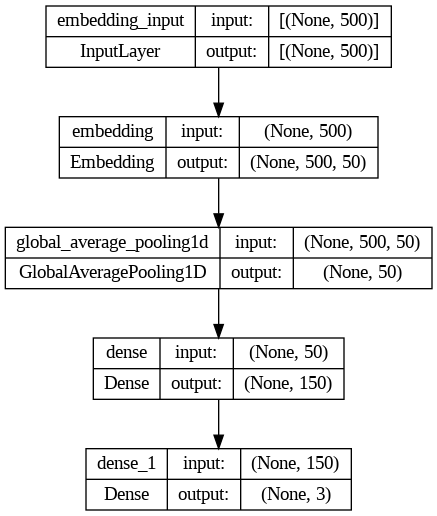

In [18]:
plot_model(model,show_shapes=True,to_file='model.png')
display_png(Image('model.png'))

In [19]:
history = model.fit(train_x,train_y,batch_size=128,epochs=10,validation_data=(dev_x,dev_y))

Epoch 1/10
188/188 [==============================] - 6s 19ms/step - loss: 0.7858 - accuracy: 0.6386 - val_loss: 0.7898 - val_accuracy: 0.6366
Epoch 2/10
188/188 [==============================] - 2s 13ms/step - loss: 0.7597 - accuracy: 0.6447 - val_loss: 0.7677 - val_accuracy: 0.6413
Epoch 3/10
188/188 [==============================] - 2s 13ms/step - loss: 0.7534 - accuracy: 0.6472 - val_loss: 0.7596 - val_accuracy: 0.6424
Epoch 4/10
188/188 [==============================] - 3s 17ms/step - loss: 0.7507 - accuracy: 0.6497 - val_loss: 0.7579 - val_accuracy: 0.6439
Epoch 5/10
188/188 [==============================] - 4s 19ms/step - loss: 0.7479 - accuracy: 0.6517 - val_loss: 0.7634 - val_accuracy: 0.6449
Epoch 6/10
188/188 [==============================] - 4s 20ms/step - loss: 0.7457 - accuracy: 0.6507 - val_loss: 0.7665 - val_accuracy: 0.6406
Epoch 7/10
188/188 [==============================] - 5s 24ms/step - loss: 0.7440 - accuracy: 0.6530 - val_loss: 0.7567 - val_accuracy: 0.6439

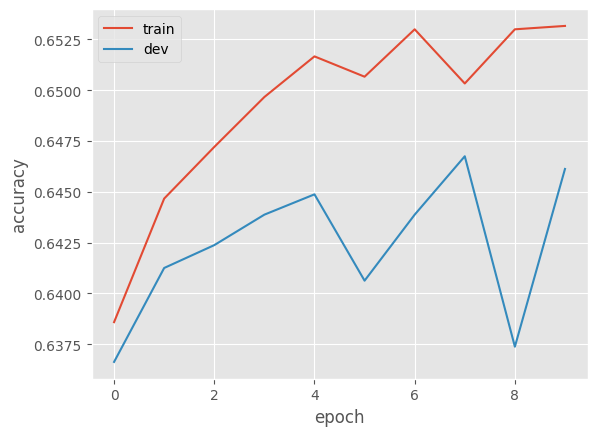

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

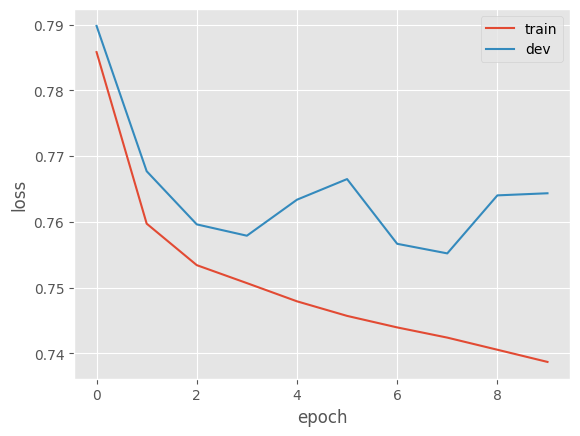

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [22]:
prediction = [np.argmax(x) for x in model.predict(dev_x)]
print(classification_report(dev['label'], prediction))

250/250 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.52      0.04      0.07       452
           1       0.53      0.06      0.11      2449
           2       0.65      0.98      0.78      5099

    accuracy                           0.65      8000
   macro avg       0.56      0.36      0.32      8000
weighted avg       0.61      0.65      0.54      8000



# Convolutional Neural Network

In [23]:
from keras.src.layers import GlobalMaxPool1D
from keras import regularizers

def make_cnn_model(print_model=True):

    filters = 250 #number of Filters in your Convnet
    kernel_size= 3 #a window size of 3 tokens
    hidden_dims = 250 #number of neurons at the normal feedforward NN

    cnn_model = Sequential()
    Input_length = max_len #max_len is the maximum length of the sentence in your dataset.

    cnn_model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], mask_zero=True,
                            trainable=False))

    cnn_model.add(Conv1D(filters=filters,
                        kernel_size=kernel_size,
                        input_shape=(max_len, embedding_matrix.shape[1]),
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.01)))

    cnn_model.add(GlobalMaxPool1D())
    # GlobalMaxPooling1D(n) default 2.

    cnn_model.add(Dense(hidden_dims, activation='relu'))
    cnn_model.add(Dropout(0.4))
    cnn_model.add(Dense(3, activation='softmax'))

    # compile model
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    if print_model:
        cnn_model.summary()
        plot_model(cnn_model, show_shapes=True, to_file='model.png')
        display(Image('model.png'))

    return cnn_model


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          3081600   
                                                                 
 conv1d (Conv1D)             (None, None, 250)         37750     
                                                                 
 global_max_pooling1d (Glob  (None, 250)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 250)               62750     
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 753       
                                                      

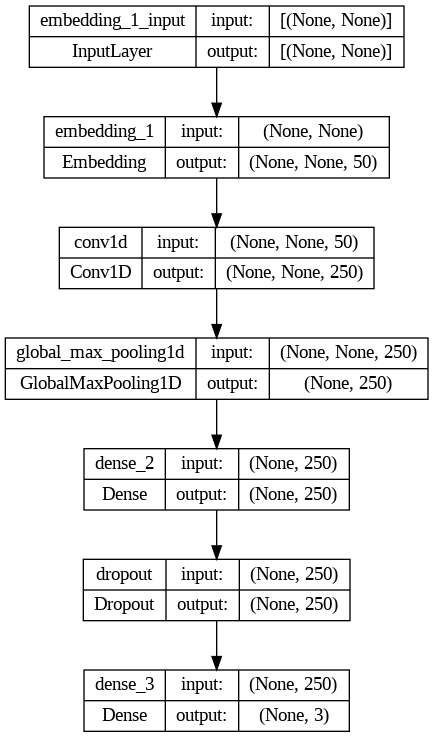

In [24]:
cnn_model=make_cnn_model()

In [25]:
history = cnn_model.fit(train_x,train_y,batch_size=128,epochs=10,validation_data=(dev_x,dev_y))

Epoch 1/10
188/188 [==============================] - 99s 524ms/step - loss: 1.4047 - accuracy: 0.6257 - val_loss: 1.0254 - val_accuracy: 0.6407
Epoch 2/10
188/188 [==============================] - 88s 467ms/step - loss: 0.8999 - accuracy: 0.6600 - val_loss: 0.8114 - val_accuracy: 0.6578
Epoch 3/10
188/188 [==============================] - 87s 465ms/step - loss: 0.7825 - accuracy: 0.6739 - val_loss: 0.7613 - val_accuracy: 0.6845
Epoch 4/10
188/188 [==============================] - 87s 463ms/step - loss: 0.7466 - accuracy: 0.6847 - val_loss: 0.7600 - val_accuracy: 0.6639
Epoch 5/10
188/188 [==============================] - 87s 463ms/step - loss: 0.7351 - accuracy: 0.6894 - val_loss: 0.7425 - val_accuracy: 0.6899
Epoch 6/10
188/188 [==============================] - 87s 463ms/step - loss: 0.7236 - accuracy: 0.6971 - val_loss: 0.7499 - val_accuracy: 0.6781
Epoch 7/10
188/188 [==============================] - 88s 467ms/step - loss: 0.7126 - accuracy: 0.7043 - val_loss: 0.7380 - val_ac

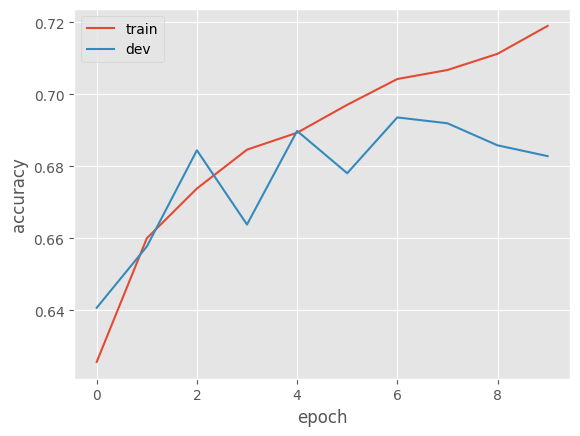

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

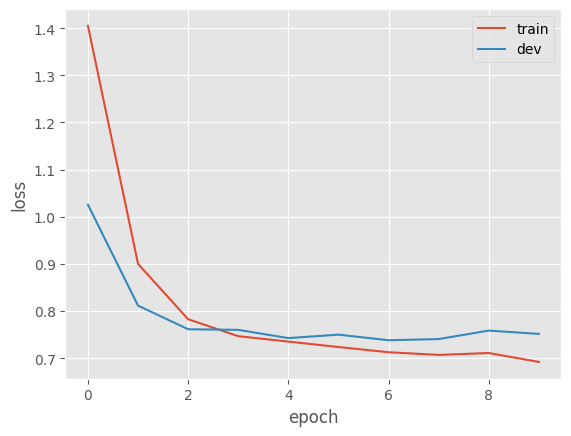

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [28]:
prediction = [np.argmax(x) for x in cnn_model.predict(dev_x)]
print(classification_report(dev['label'], prediction))

250/250 [==============================] - 9s 37ms/step
              precision    recall  f1-score   support

           0       0.57      0.23      0.33       452
           1       0.50      0.52      0.51      2449
           2       0.77      0.80      0.79      5099

    accuracy                           0.68      8000
   macro avg       0.62      0.52      0.54      8000
weighted avg       0.68      0.68      0.68      8000



# Recurrent Neural Network

In [29]:
#ref: https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

def make_rnn_model(print_model=True):

    filters = 250 #number of Filters in your Convnet
    kernel_size= 3 #a window size of 3 tokens
    hidden_dims = 250 #number of neurons at the normal feedforward NN

    rnn_model = Sequential()
    Input_length = max_len #max_len is the maximum length of the sentence in your dataset.

    rnn_model.add(
        Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  weights=[embedding_matrix],
                  mask_zero=True,
                  trainable=False))

    # Masking layer for pre-trained embeddings
    rnn_model.add(Masking(mask_value=0.0))

    # Recurrent layer
    rnn_model.add(LSTM(64, return_sequences=False,
                  dropout=0.1, recurrent_dropout=0.1))

    # Fully connected layer
    rnn_model.add(Dense(64, activation='relu'))

    # Dropout for regularization
    rnn_model.add(Dropout(0.5))


    rnn_model.add(Dense(3, activation='softmax'))

    # compile model
    rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    if print_model:
        rnn_model.summary()
        plot_model(rnn_model, show_shapes=True, to_file='rnn_model.png')
        display(Image('rnn_model.png'))

    return rnn_model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          3081600   
                                                                 
 masking (Masking)           (None, None, 50)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3115395 (11.88 MB)
Trainable params: 337

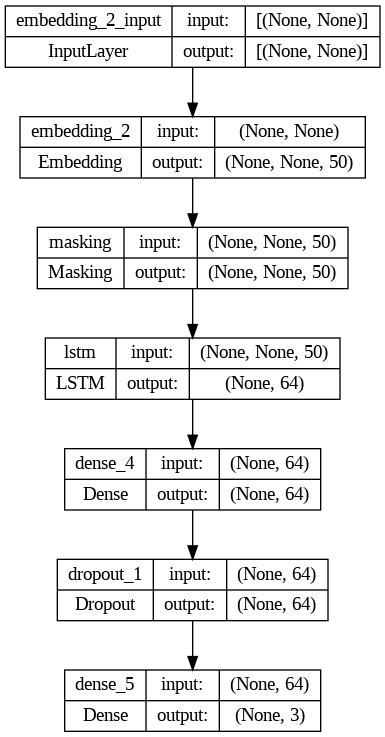

In [30]:
rnn_model=make_rnn_model()

In [31]:
history = rnn_model.fit(train_x,train_y,batch_size=128,epochs=10,validation_data=(dev_x,dev_y))

Epoch 1/10
188/188 [==============================] - 260s 1s/step - loss: 0.8276 - accuracy: 0.6322 - val_loss: 0.7766 - val_accuracy: 0.6374
Epoch 2/10
188/188 [==============================] - 255s 1s/step - loss: 0.7664 - accuracy: 0.6451 - val_loss: 0.7627 - val_accuracy: 0.6417
Epoch 3/10
188/188 [==============================] - 255s 1s/step - loss: 0.7417 - accuracy: 0.6491 - val_loss: 0.7299 - val_accuracy: 0.6560
Epoch 4/10
188/188 [==============================] - 255s 1s/step - loss: 0.7222 - accuracy: 0.6607 - val_loss: 0.7272 - val_accuracy: 0.6624
Epoch 5/10
188/188 [==============================] - 255s 1s/step - loss: 0.7018 - accuracy: 0.6677 - val_loss: 0.7032 - val_accuracy: 0.6680
Epoch 6/10
188/188 [==============================] - 255s 1s/step - loss: 0.6844 - accuracy: 0.6804 - val_loss: 0.6991 - val_accuracy: 0.6750
Epoch 7/10
188/188 [==============================] - 256s 1s/step - loss: 0.6735 - accuracy: 0.6874 - val_loss: 0.6942 - val_accuracy: 0.6726

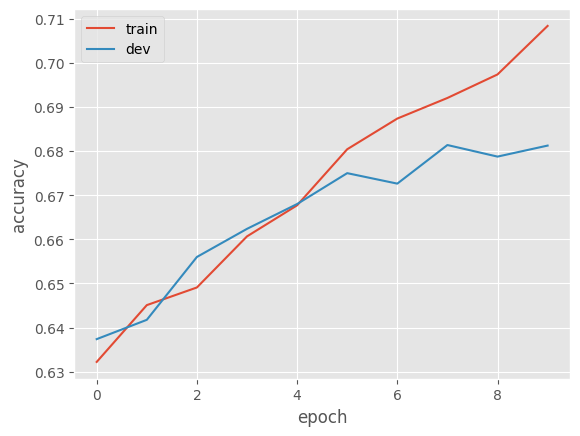

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

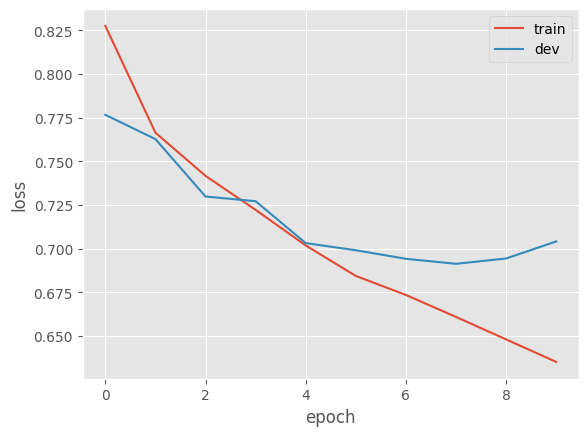

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [34]:
prediction = [np.argmax(x) for x in cnn_model.predict(dev_x)]
print(classification_report(dev['label'], prediction))

250/250 [==============================] - 9s 37ms/step
              precision    recall  f1-score   support

           0       0.57      0.23      0.33       452
           1       0.50      0.52      0.51      2449
           2       0.77      0.80      0.79      5099

    accuracy                           0.68      8000
   macro avg       0.62      0.52      0.54      8000
weighted avg       0.68      0.68      0.68      8000

